In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Project 3A/Visualization

/content/drive/MyDrive/Colab Notebooks/Project 3A/Visualization


This is a python notebook to visualize the benchmarking result. 

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict
import torch.nn.functional as F
import numpy as np

from utils import *
# from unet_parts import *

In [4]:
# We firstly load the dataset save in npy format

datapath = "dataset/example_dataset.npy"
data = np.load(datapath)

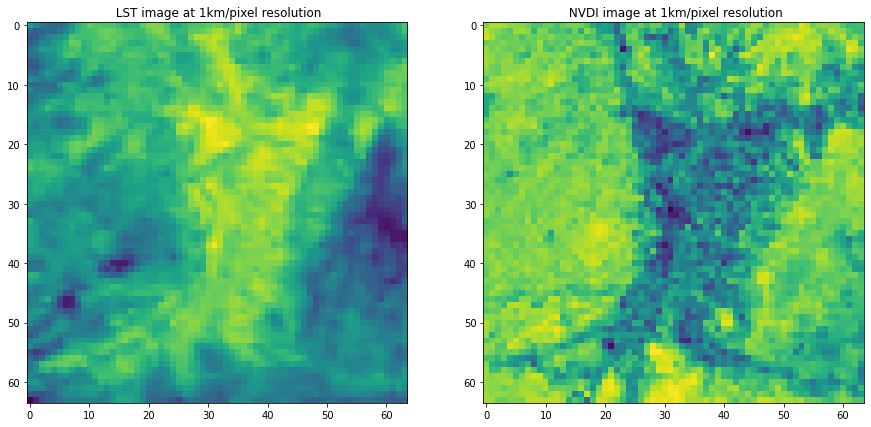

In [5]:
# Plot the first pair LST-NDVI
id = 0
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(data[id,1,:,:])
plt.title(" LST image at 1km/pixel resolution")
plt.subplot(1,2,2)
plt.imshow(data[id,0,:,:])
plt.title(" NVDI image at 1km/pixel resolution")
plt.show()

In [7]:
# Load 3 models for benchmarking. The models can be downloaded at:
# VDSR: https://drive.google.com/file/d/17OKkTVxhD4GSuSArA9bJ6Uq8WkRe1Sb1/view?usp=sharing
# DMCN: https://drive.google.com/file/d/12XNOszkNoZTM3aZPwu_LbdLd1HWESwL1/view?usp=sharing
# Multi-residual Unet: https://drive.google.com/file/d/1-BCc0-kj07p5FK4GbV_dzLb_0XEuKe6b/view?usp=sharing

from model import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vdsr = VDSR().to(device)
model_dmcn = DMCN_prelu().to(device)
model_ours = UNet(res_down=True, n_resblocks=1, bilinear=0).to(device)
model_vdsr.load_state_dict(torch.load('model_VDSR.pth'))
model_dmcn.load_state_dict(torch.load('model_DMCN.pth'))
model_ours.load_state_dict(torch.load('model_MRUnet.pth'))
model_vdsr.eval()
model_dmcn.eval()
model_ours.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [8]:
# Normalization factor and scaling factor.
max_val = 333.32000732421875
scale = 4

In [13]:
import cv2
from ATPRK import ATPRK
ind = 0
# Retrive corresponding LST and NDVI.
lst_1km = data[ind,1,:,:]
ndvi_1km = data[ind,0,:,:]
# Perform downsampling using norm 4
lst_4km = downsampling(lst_1km, 4)
ndvi_4km = downsampling(ndvi_1km,4)
# Create model input
bicubic = cv2.resize(lst_4km, lst_1km.shape, cv2.INTER_CUBIC)
input = torch.tensor(np.reshape(bicubic/max_val, (1,1,64,64)), dtype=torch.float).to(device)
# feed input into models
out_vdsr = model_vdsr(input).cpu().detach().numpy()
out_dmcn = model_dmcn(input).cpu().detach().numpy()
out_ours = model_ours(input).cpu().detach().numpy()
atprk_predictions, atprk_labels, Delta_T_final, TT_unm= ATPRK(ndvi_1km, \
                                                              lst_1km,\
                                                              ndvi_4km, \
                                                              lst_4km)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
# Metrics calculation
PSNR_bicubic, rmse_bicubic = psnr_notorch(lst_1km, bicubic)
PSNR_vdsr, rmse_vdsr = psnr_notorch(lst_1km[4:-4, 4:-4], out_vdsr[0,0,:,:][4:-4, 4:-4]*max_val)
PSNR_dmcn, rmse_dmcn = psnr_notorch(lst_1km[4:-4, 4:-4], out_dmcn[0,0,:,:][4:-4, 4:-4]*max_val)
PSNR_ours, rmse_ours = psnr_notorch(lst_1km[4:-4, 4:-4], out_ours[0,0,:,:][4:-4, 4:-4]*max_val)
PSNR_atprk, rmse_atprk = psnr_notorch(lst_1km[4:-4, 4:-4], atprk_predictions[4:-4, 4:-4])
ssim_bicubic = ssim(lst_1km, bicubic)
ssim_vdsr = ssim(lst_1km[4:-4, 4:-4], out_vdsr[0,0,:,:][4:-4, 4:-4]*max_val)
ssim_dmcn = ssim(lst_1km[4:-4, 4:-4], out_dmcn[0,0,:,:][4:-4, 4:-4]*max_val)
ssim_ours = ssim(lst_1km[4:-4, 4:-4], out_ours[0,0,:,:][4:-4, 4:-4]*max_val)
ssim_atprk = ssim(lst_1km[4:-4, 4:-4], atprk_predictions[4:-4, 4:-4])

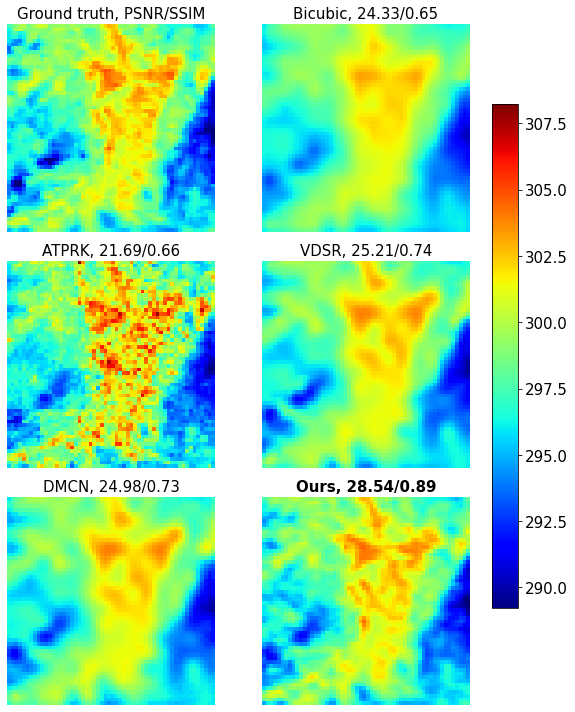

In [15]:
# Plot the benchmarking result
from mpl_toolkits.axes_grid1 import make_axes_locatable
fontsize = 15
vmin = atprk_predictions[4:-4, 4:-4].min()
vmax = atprk_predictions[4:-4, 4:-4].max()
clmap = 'jet'
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
im1 = ax[0,0].imshow(lst_1km[4:-4, 4:-4], vmin = vmin, vmax = vmax, cmap = clmap)
ax[0,0].set_title("Ground truth, PSNR/SSIM", fontsize=fontsize)
ax[0,0].axis('off')

im2 = ax[0,1].imshow(bicubic[4:-4, 4:-4], vmin = vmin, vmax = vmax, cmap = clmap)
ax[0,1].set_title("Bicubic, {:.2f}/{:.2f}".format(PSNR_bicubic,ssim_bicubic), fontsize=fontsize)
ax[0,1].axis('off')

im3 = ax[1,0].imshow(atprk_predictions[4:-4, 4:-4], vmin = vmin, vmax = vmax, cmap = clmap)
ax[1,0].set_title("ATPRK, {:.2f}/{:.2f}".format(PSNR_atprk, ssim_atprk), fontsize=fontsize)
ax[1,0].axis('off')

im4 = ax[1,1].imshow(out_vdsr[0,0,:,:][4:-4, 4:-4]*max_val, vmin = vmin, vmax = vmax, cmap = clmap)
ax[1,1].set_title("VDSR, {:.2f}/{:.2f}".format(PSNR_vdsr, ssim_vdsr), fontsize=fontsize)
ax[1,1].axis('off')

im5 = ax[2,0].imshow(out_dmcn[0,0,:,:][4:-4, 4:-4]*max_val, vmin = vmin, vmax = vmax, cmap = clmap)
ax[2,0].set_title("DMCN, {:.2f}/{:.2f}".format(PSNR_dmcn, ssim_dmcn), fontsize=fontsize)
ax[2,0].axis('off')

im6 = ax[2,1].imshow(out_ours[0,0,:,:][4:-4, 4:-4]*max_val, vmin = vmin, vmax = vmax, cmap = clmap)
ax[2,1].set_title("Ours, {:.2f}/{:.2f}".format(PSNR_ours, ssim_ours), fontweight="bold", fontsize=fontsize)
ax[2,1].axis('off')

# cmap = plt.get_cmap('jet',20)
fig.tight_layout()
fig.subplots_adjust(right=0.7)
cbar_ax = fig.add_axes([0.65, 0.15, 0.03, 0.7])
cbar_ax.tick_params(labelsize=15)
fig.colorbar(im1, cax=cbar_ax, cmap = clmap)

# plt.savefig("Results/index_" + str(ind) + clmap+ ".png",  bbox_inches='tight')
plt.show()